<a href="https://colab.research.google.com/github/HalimaLadan/CNN-Projects/blob/main/Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plant Seedlings Classification

# Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

# Importing necessary libraries

In [ ]:
#Data and image manipulation libraries
import numpy as np
import pandas as pd

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Display images using OpenCV
from google.colab.patches import cv2_imshow
import cv2

#Machine Learning Libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #sequential api for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend

#Preprocessing Libraries
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding

from tensorflow.keras.optimizers import RMSprop,Adam,SGD #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses

# Importing all the required sub-modules from Keras for image processing
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


# Loading the dataset

In [ ]:
# Mounting Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the image file.
images = np.load("/content/images.npy")

# Loading the labels file.
labels = pd.read_csv("/content/Labels (1).csv")


# Data Overview

### Understanding the shape of the dataset

In [ ]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

####Plotting images using OpenCV.


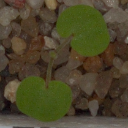

In [ ]:
cv2_imshow(images[4])

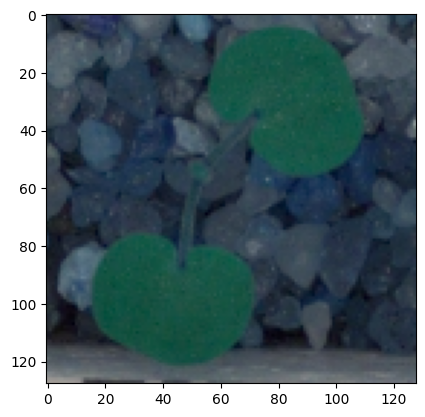

In [ ]:
plt.imshow(images[4])

* We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV. Now lets take a look at alll the categories before converting them to  RGB format which is more interpretable format for the machine learning algorithmn.

In [ ]:
#Defining a function that will the images and labels
# and then produce a 12,8 sized plot with 3 rows and 4 columns of labeled images.
def images_plots (images, labels):
  num_classes = 12
  categories =np.unique(labels)
  keys =dict(labels["Label"])
  rows = 3
  cols = 4
  fig = plt.figure(figsize = (10,8))
  for i in range (cols):
    for j in range (rows):
      random_index = np.random.randint(0, len(labels))
      ax =fig.add_subplot(rows, cols, i*rows + j+1)
      ax.imshow(images[random_index, :])
      ax.set_title(keys[random_index])
plt.show()

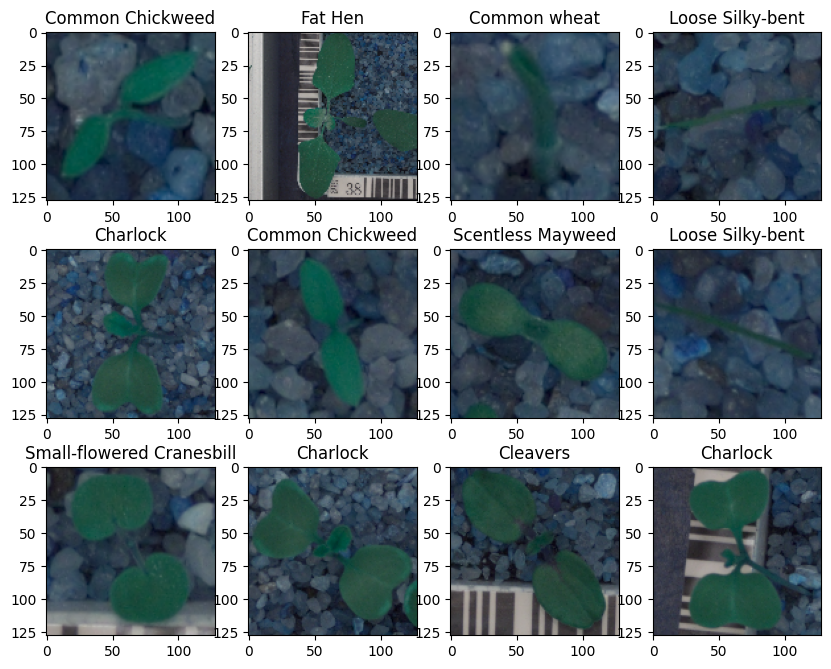

In [ ]:
images_plots(images, labels)

###Imbalance Data Check

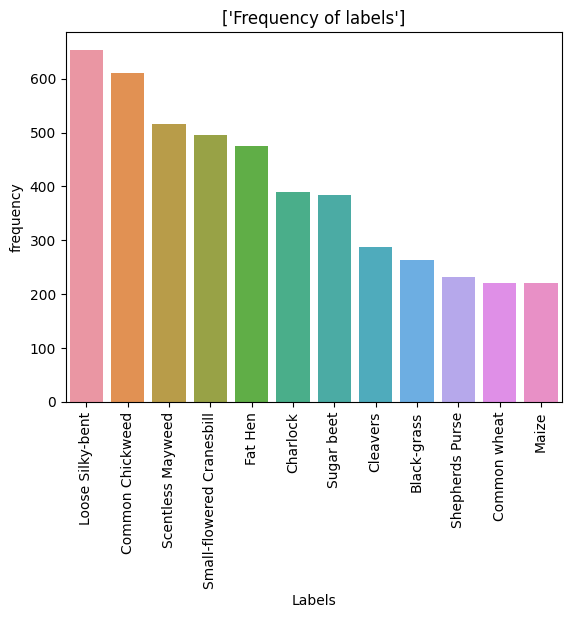

In [ ]:
label_count = labels["Label"].value_counts()
sns.barplot(x=label_count.index, y=label_count.values)
plt.xlabel("Labels")
plt.xticks(rotation =90)
plt.ylabel('frequency')
plt.title(['Frequency of labels'])
plt.show()

As you can see from the above plot, the dataset is quite imbalanced. The top most occuring plants, which are the Loose silky bent and the common chicweed plants appeared almost three times as much as the three least appearing plants, which are the Shepherds purse, common wheat and Maize.

This will affect the performance of the model in predicting the least appearing classes, the model will give more importance to the more occuring plant species, while ignoring the least occuring ones. This will be addressed by generating more of the least appearing plants to balance the dataset, However we will build a model using the imbalanced data, and then build another with a balanced data through augumentation, and then compare the performance of both models..

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
for i in range (len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

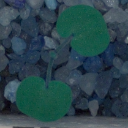

In [ ]:
cv2_imshow(images[4])

Sample image after conversion to RGB

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
decreased_images =[]
height= 64
width = 64
dimensions =(width,height)
for i in range(len(images)):
  decreased_images.append(cv2.resize(images[i], dimensions, interpolation =cv2.INTER_LINEAR))


Image before resizing

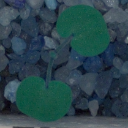

In [ ]:
cv2_imshow(images[4])

Image after resizing

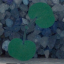

In [ ]:
cv2_imshow(decreased_images[4])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(decreased_images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)


(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [ ]:
#Use of the labelbinarizer to encode labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [ ]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

Now, let's build a CNN Model with the following 2 main parts -

The Feature Extraction layers which are comprised of convolutional and pooling layers.
The Fully Connected classification layers for prediction.


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [ ]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 58s - loss: 2.4534 - accuracy: 0.1258 - val_loss: 2.3999 - val_accuracy: 0.1495 - 58s/epoch - 481ms/step
Epoch 2/30
121/121 - 47s - loss: 2.3211 - accuracy: 0.1781 - val_loss: 2.1971 - val_accuracy: 0.2266 - 47s/epoch - 386ms/step
Epoch 3/30
121/121 - 43s - loss: 2.1247 - accuracy: 0.2423 - val_loss: 1.9983 - val_accuracy: 0.3294 - 43s/epoch - 352ms/step
Epoch 4/30
121/121 - 44s - loss: 2.0064 - accuracy: 0.2831 - val_loss: 1.8571 - val_accuracy: 0.3528 - 44s/epoch - 368ms/step
Epoch 5/30
121/121 - 43s - loss: 1.9794 - accuracy: 0.2849 - val_loss: 1.8021 - val_accuracy: 0.3528 - 43s/epoch - 356ms/step
Epoch 6/30
121/121 - 46s - loss: 1.9521 - accuracy: 0.2893 - val_loss: 1.7697 - val_accuracy: 0.3551 - 46s/epoch - 383ms/step
Epoch 7/30
121/121 - 49s - loss: 1.9287 - accuracy: 0.2771 - val_loss: 1.7389 - val_accuracy: 0.3621 - 49s/epoch - 405ms/step
Epoch 8/30
121/121 - 45s - loss: 1.8656 - accuracy: 0.2932 - val_loss: 1.6631 - val_accuracy: 0.3925 - 45s/epoch - 372

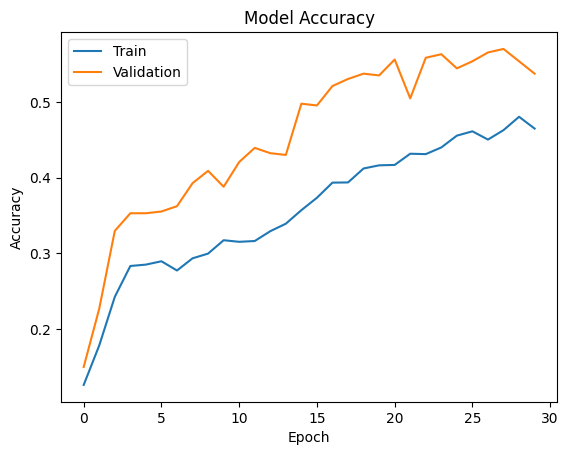

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observations:

* We can see from the above plot that the training accuracy of the model was not so good and the validation accuracy was worst.
*The model seems to overfit on the data.

#### Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.3609 - accuracy: 0.5516 - 1s/epoch - 71ms/step


The accuracy  on the test data is not so impressive

### Generating the predictions using test data


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 1s 75ms/step


### Plotting the Confusion Matrix
* The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
* The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,
 we must retrieve the categorical values from the encoded values.


We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

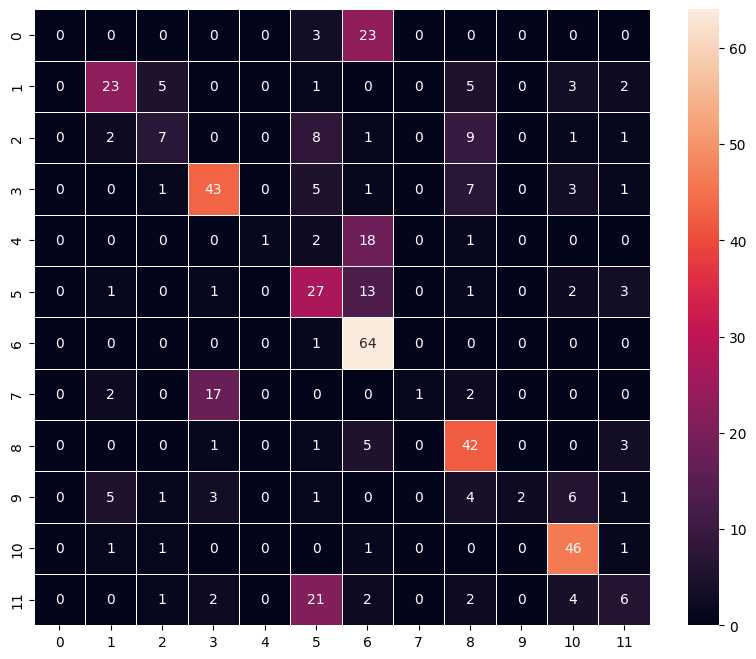

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


### Observations

* We observe that some of the classes are not predicted correctly.
* In comparison to the rest, we can see that classes 3,6,8, and 10 are well classified.
* We can also observe that classes 0,2,4,7 and 9 are mostly misclassified.



## Model Performance Improvement by increasing model complexity




As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

**Reducing the Learning Rate:**

ReduceLRonPlateau() is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### **Data Augmentation**

Data Augmentation¶
In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is Data Augmentation. CNNs have the property of translational invariance, which means they can recognise an object even if its appearance shifts translationally in some way.
Taking this attribute into account, we can augment the images using the techniques listed below -
1. Horizontal Flip (should be set to True/False)
2. Vertical Flip (should be set to True/False)
3. Height Shift (should be between 0 and 1)
4. Width Shift (should be between 0 and 1)
5. Rotation (should be between 0 and 180)
6. Shear (should be between 0 and 1)
7. Zoom (should be between 0 and 1) etc.


In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
# Intializing a sequential model
Aug_model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
Aug_model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
Aug_model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
Aug_model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
Aug_model.add(MaxPooling2D((2, 2), padding = 'same'))
Aug_model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
Aug_model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
Aug_model.add(Dense(16, activation='relu'))
Aug_model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
Aug_model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
Aug_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
Aug_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

Aug_history = Aug_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/25
60/60 [==============================] - 8s 84ms/step - loss: 2.1334 - accuracy: 0.2456 - val_loss: 2.3890 - val_accuracy: 0.1846
Epoch 2/25
60/60 [==============================] - 4s 70ms/step - loss: 1.7185 - accuracy: 0.3955 - val_loss: 2.3118 - val_accuracy: 0.2360
Epoch 3/25
60/60 [==============================] - 6s 98ms/step - loss: 1.5176 - accuracy: 0.4615 - val_loss: 2.2030 - val_accuracy: 0.1893
Epoch 4/25
60/60 [==============================] - 4s 71ms/step - loss: 1.4401 - accuracy: 0.5030 - val_loss: 2.0764 - val_accuracy: 0.3972
Epoch 5/25
60/60 [==============================] - 8s 131ms/step - loss: 1.3396 - accuracy: 0.5223 - val_loss: 1.7496 - val_accuracy: 0.4509
Epoch 6/25
60/60 [==============================] - 4s 70ms/step - loss: 1.2586 - accuracy: 0.5596 - val_loss: 1.6773 - val_accuracy: 0.5631
Epoch 7/25
60/60 [==============================] - 6s 98ms/step - loss: 1.1998 - accuracy: 0.5781 - val_loss: 1.3106 - val_accuracy: 0.6682
Epoch 8/25
6

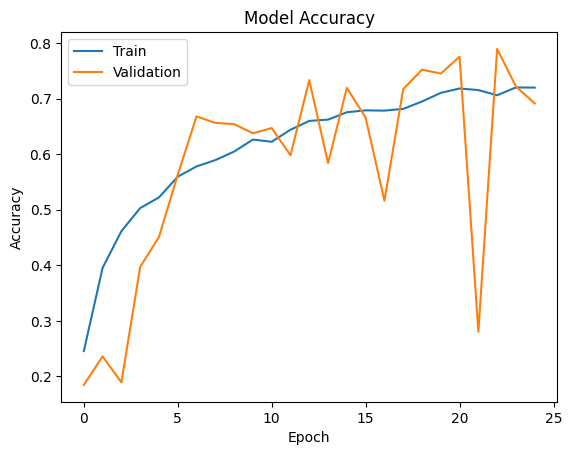

In [ ]:
plt.plot(Aug_history.history['accuracy'])
plt.plot(Aug_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The overfitting on the validation set has reduced and the accuracy has also increased.

In [ ]:
Aug_accuracy = Aug_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.1643 - accuracy: 0.6505 - 80ms/epoch - 5ms/step


We can observe that our accuracy has slightly improved compared to our previous model.

In [ ]:
# Here we would get the output as probablities for each category
y_pred=Aug_model.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


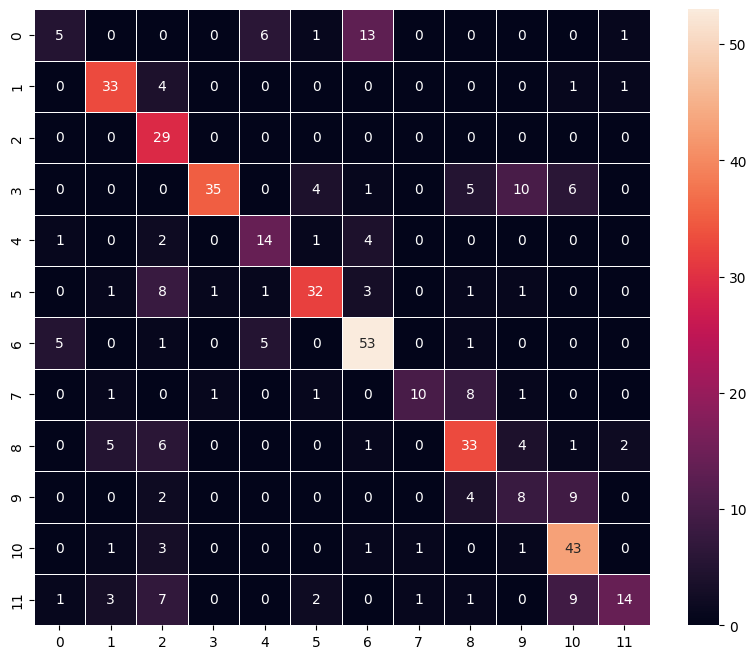

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

There are still a number of classes that are misclassifies, such as 6 and 9 classes.

## Final Model

### Visualizing the prediction

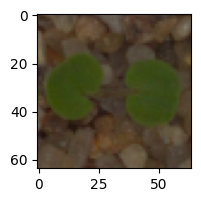

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


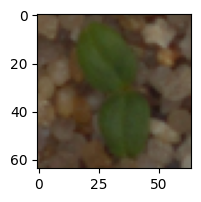

1/1 [==============================] - 0s 26ms/step
Predicted Label ['Cleavers']
True Label Cleavers


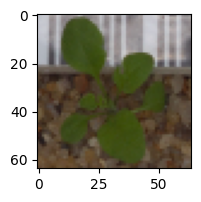

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Shepherds Purse


In [ ]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(Aug_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(Aug_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(Aug_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

###Conclusion
We can observe from the accuracy score as well as the confusion matrix of both models , that the model with augumented data was the best model even though it only predicted classes slightly better than the other model.
The test accuracy of the first model without augumentation is 60%, while the test accuracy result on the model with augumented data is 65%.
Data Augmentation has helped in improving the model.

In [ ]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['64%','70%','77%'],'Validation Accuracy':['48%','53%','63%'],'Test Accuracy':['51%','62%','63%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,64%,48%,51%
1,CNN Model with Data Augmentation,70%,53%,62%
2,Transfer Learning Model,77%,63%,63%


## Actionable Insights
The species of the plants can be classified using the above model, however the model has room for further improvements.

# Business Recommendations:

* The model can be further improved by training with different filter sizes and different number of filters.
* The model can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
* Spatial dropout may also be introduced to reduce over fitting.
* More Data Augmentation can be performed and dropout_rate can be changed to improve the model performance.
* Transfer Learning technique can be applied to improve the model performance

In [ ]:
!pip install nbconvert

In [ ]:
%%shell
jupyter nbconvert --to html ///content/Plant_Seedling_Classification.ipynb

[NbConvertApp] Converting notebook ///content/Plant_Seedling_Classification.ipynb to html
[NbConvertApp] Writing 2213192 bytes to /content/Plant_Seedling_Classification.html
